In [308]:
cd ~/data/modl_data/pipeline/contrast/prediction/166/

/storage/store/work/amensch/data/modl_data/pipeline/contrast/prediction/166


In [319]:
ls

estimator.pkl  label_encoder.pkl  prediction.csv


In [309]:
from sklearn.externals.joblib import load
from sklearn.pipeline import Pipeline
import pandas as pd

from nilearn.input_data import MultiNiftiMasker
from nilearn.datasets import load_mni152_brain_mask
from modl.datasets.hcp import fetch_hcp

In [310]:
%matplotlib inline

def plot_confusion_matrix(conf_arr, labels):

    fig = plt.figure(figsize=(8, 8))
    plt.clf()
    ax = fig.add_subplot(111)
    ax.set_aspect(1)
    
    S = conf_arr.sum(axis=0)
    S[S == 0] = 1
    conf_arr = conf_arr / S
    
    res = ax.imshow(conf_arr,
                interpolation='nearest')

    width, height = conf_arr.shape

    plt.xticks(range(width))
    plt.yticks(range(height))
    ax.set_yticklabels(labels)
    ax.set_xticklabels(labels, rotation=90)
    fig.colorbar(res)
    
def plot_gram_matrix(G, labels):
    fig = plt.figure(figsize=(8, 8))
    plt.clf()
    ax = fig.add_subplot(111)
    ax.set_aspect(1)
    res = ax.imshow(G,
                interpolation='nearest')

    width, height = G.shape

    plt.xticks(range(width))
    plt.yticks(range(height))
    ax.set_yticklabels(labels)
    ax.set_xticklabels(labels, rotation=90)
    fig.colorbar(res)

In [311]:
cd _artifacts

/storage/store/work/amensch/data/modl_data/pipeline/contrast/prediction/166/_artifacts


In [312]:
from modl.fixes import OurModel
estimator = load('estimator.pkl')
label_encoder = load('label_encoder.pkl')
prediction = pd.read_csv('prediction.csv')

In [313]:
estimator.named_steps['classifier']

FactoredLogistic(activation='linear', alpha=0.0001, batch_size=200,
         dropout=False, fit_intercept=True, latent_dim=100, max_iter=10,
         n_jobs=24, optimizer='adam', penalty='l1',
         random_state=<mtrand.RandomState object at 0x7f417bd7aaf8>,
         validation_split=0)

In [314]:
model = estimator.steps[-1][1].stacked_model_

supervised_layers =  model.layers_by_depth[2]
embedding_layer =  model.layers_by_depth[3][0]

w0 = []
for layer in supervised_layers:
    this_w0, this_b0 = layer.get_weights()
    w0.append(this_w0)
w0 = np.concatenate(w0, axis=1)
w1 = embedding_layer.get_weights()[0]

coef = w1.dot(w0).T

In [315]:
print('Sparsity', (coef == 0).sum() / coef.size)

Sparsity 0.0


In [316]:
match = prediction['true_label'] == prediction['predicted_label']
prediction = prediction.assign(match=match)
prediction.set_index(['fold', 'dataset', 'subject', 'task', 'contrast', 'direction'], inplace=True)
prediction.sort_index(inplace=True)
datasets = prediction.index.get_level_values('dataset').unique().values

In [317]:
prediction.loc['train', 'match']

dataset  subject  task        contrast              direction
archi    2        emotional   expression_control    level1        True
                              expression_intention  level1        True
                              expression_sex        level1       False
                              face_control          level1        True
                              face_sex              level1       False
                              face_trusty           level1        True
                  localizer   audio                 level1        True
                              calculaudio           level1        True
                              calculvideo           level1        True
                              clicDaudio            level1        True
                              clicDvideo            level1        True
                              clicGaudio            level1        True
                              clicGvideo            level1        True
               

In [318]:
labels_list = []
tasks_list = []
for dataset in datasets:
    first_subject = prediction.loc['test', dataset].index.get_level_values('subject')[0]
    data = prediction.loc[('test', dataset, first_subject)]
    labels = data.index.get_level_values('contrast').values
    tasks = data.index.get_level_values('task').values
    labels_list.append(labels)
    tasks_list.append(tasks)
labels = np.concatenate(labels_list)
tasks = np.concatenate(tasks_list)

In [303]:
from sklearn.metrics import confusion_matrix

In [304]:
train_conf = confusion_matrix(prediction.loc['train', 'true_label'],
                        prediction.loc['train', 'predicted_label'], labels=labels)
test_conf = confusion_matrix(prediction.loc['test', 'true_label'],
                        prediction.loc['test', 'predicted_label'], labels=labels)

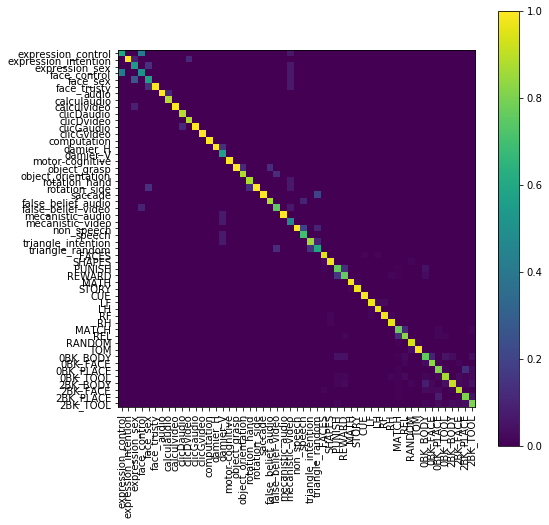

In [278]:
plot_confusion_matrix(test_conf, labels)

In [279]:
prediction['match'].groupby(level=['fold', 'dataset', 'task', 'contrast']).apply(np.mean)['test']

dataset  task        contrast            
archi    emotional   expression_control      0.375000
                     expression_intention    0.750000
                     expression_sex          0.750000
                     face_control            0.625000
                     face_sex                0.500000
                     face_trusty             0.750000
         localizer   audio                   0.875000
                     calculaudio             1.000000
                     calculvideo             0.875000
                     clicDaudio              1.000000
                     clicDvideo              1.000000
                     clicGaudio              0.875000
                     clicGvideo              1.000000
                     computation             1.000000
                     damier_H                0.750000
                     damier_V                1.000000
                     motor-cognitive         1.000000
         parietal    object_grasp       

In [280]:
prediction['match'].groupby(level=['fold', 'dataset']).apply(np.mean)

fold   dataset
test   archi      0.812500
       hcp        0.889381
train  archi      0.975714
       hcp        0.928484
Name: match, dtype: float64

In [281]:
classifier = estimator.named_steps['classifier']

In [285]:
histories = classifier.histories_

In [288]:
history.epoch

[1.0,
 2.0,
 3.0,
 4.0,
 5.0,
 6.0,
 7.0,
 8.0,
 9.0,
 10.0,
 11.0,
 12.0,
 13.0,
 14.0,
 15.0,
 16.0,
 17.0,
 18.0,
 19.0,
 20.0,
 21.0,
 22.0,
 23.0,
 24.0,
 25.0,
 26.0,
 27.0,
 28.0,
 29.0,
 30.0,
 31.0,
 32.0,
 33.0,
 34.0,
 35.0,
 36.0,
 37.0,
 38.0,
 39.0,
 40.0,
 41.0,
 42.0,
 43.0,
 44.0,
 45.0,
 46.0,
 47.0,
 48.0,
 49.0,
 50.0,
 51.0,
 52.0,
 53.0,
 54.0,
 55.0,
 56.0,
 57.0,
 58.0,
 59.0,
 60.0,
 61.0,
 62.0,
 63.0,
 64.0,
 65.0,
 66.0,
 67.0,
 68.0,
 69.0,
 70.0,
 71.0,
 72.0,
 73.0,
 74.0,
 75.0,
 76.0,
 77.0,
 78.0,
 79.0,
 80.0,
 81.0,
 82.0,
 83.0,
 84.0,
 85.0,
 86.0,
 87.0,
 88.0,
 89.0,
 90.0,
 91.0,
 92.0,
 93.0,
 94.0,
 95.0,
 96.0,
 97.0,
 98.0,
 99.0,
 100.0,
 101.0,
 102.0,
 103.0,
 104.0,
 105.0,
 106.0,
 107.0,
 108.0,
 109.0,
 110.0,
 111.0,
 112.0,
 113.0,
 114.0,
 115.0,
 116.0,
 117.0,
 118.0,
 119.0,
 120.0,
 121.0,
 122.0,
 123.0,
 124.0,
 125.0,
 126.0,
 127.0,
 128.0,
 129.0,
 130.0,
 131.0,
 132.0,
 133.0,
 134.0,
 135.0,
 136.0,
 137.0,
 138.0,
 139

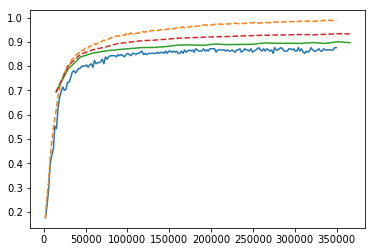

In [292]:
for history, n_samples in zip(histories, classifier.n_samples_):
    plt.plot(np.array(history.epoch) * n_samples, history.history['val_acc'])

In [707]:
titles = ["%s: %s" % (task, contrast) for task, contrast in zip(tasks, labels)]

In [ ]:
%matplotlib inline
from nilearn.plotting import plot_stat_map
from nilearn.image import index_img
from nilearn._utils import check_niimg

indices = label_encoder.transform(labels)

imgs = check_niimg(imgs)
imgs.get_data()

plt.close('all')

for i, title in zip(indices, titles):
    plot_stat_map(index_img(imgs, i), title=title, threshold=0)

KeyboardInterrupt: 

ERROR:tornado.general:Uncaught exception, closing connection.
Traceback (most recent call last):
  File "/home/parietal/amensch/opt/miniconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/home/parietal/amensch/opt/miniconda3/lib/python3.6/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/parietal/amensch/opt/miniconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 276, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/parietal/amensch/opt/miniconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 228, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/parietal/amensch/opt/miniconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 390, in execute_request
    user_expressions, allow_stdin)
  File "/home/parietal/amensch/opt/miniconda3/lib/python3.6/site-packages/ipykernel/ipkernel

In [ ]:
indices = label_encoder.transform(labels)
ncoef = coef[indices]
S = np.sqrt((ncoef ** 2).sum(axis=1))
ncoef = ncoef / S[:, np.newaxis]

In [ ]:
G = ncoef.dot(ncoef.T)
plot_gram_matrix(G, labels)

In [619]:
np.mean(w0 == 0),np.mean(w1 == 0)

(0.0, 0.0)

In [620]:
np.histogram(w1)

(array([   34,   223,  1099,  4358,  8492, 10087,  6574,  2116,   493,   124]),
 array([ -5.41468558e-04,  -4.37985052e-04,  -3.34501546e-04,
         -2.31018040e-04,  -1.27534533e-04,  -2.40510271e-05,
          7.94324791e-05,   1.82915985e-04,   2.86399492e-04,
          3.89882998e-04,   4.93366504e-04]))

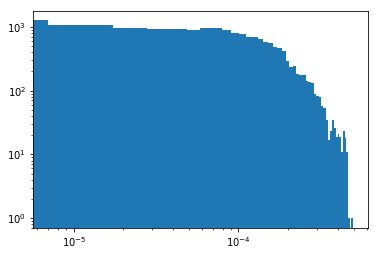

In [623]:
%matplotlib inline
n, bins, patches = plt.hist(w1.ravel(), bins=100, log=True)
plt.xscale('log')

In [ ]:
w1.ravel()[:300]

In [ ]:
(np.abs(coef[indices,:16]).sum())

In [ ]:
(np.abs(coef[indices,16:80])).sum()

In [ ]:
np.abs(coef[indices,80:80 + 256]).sum()

In [ ]:
np.mean(coef[indices, :16] == 0)

In [ ]:
np.mean(coef[indices, 16:80] == 0)

In [ ]:
np.mean(coef[indices, 80:256] == 0)